This notebook is entirely based on https://www.tensorflow.org/tutorials/images/classification

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
random_seed = 3093453

#batch_size = 256
batch_size = 128
img_height = 299
img_width = 299

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
data_dir = os.path.join(cwd, "dataset")
data_dir

'/Users/fynn/Projects/PokeDex/dataset'

In [4]:
# Before gif: 4421 files
# after Gif 135387
# After Downsampling: 18345
# One per gif: 6633
# with tcg: 20808
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=random_seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=random_seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20810 files belonging to 1006 classes.
Using 18729 files for training.


2024-04-19 21:53:37.428795: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-19 21:53:37.428825: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-19 21:53:37.428831: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-19 21:53:37.428894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 21:53:37.429086: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20810 files belonging to 1006 classes.
Using 2081 files for validation.


2024-04-19 21:53:38.199839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-19 21:53:38.201398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


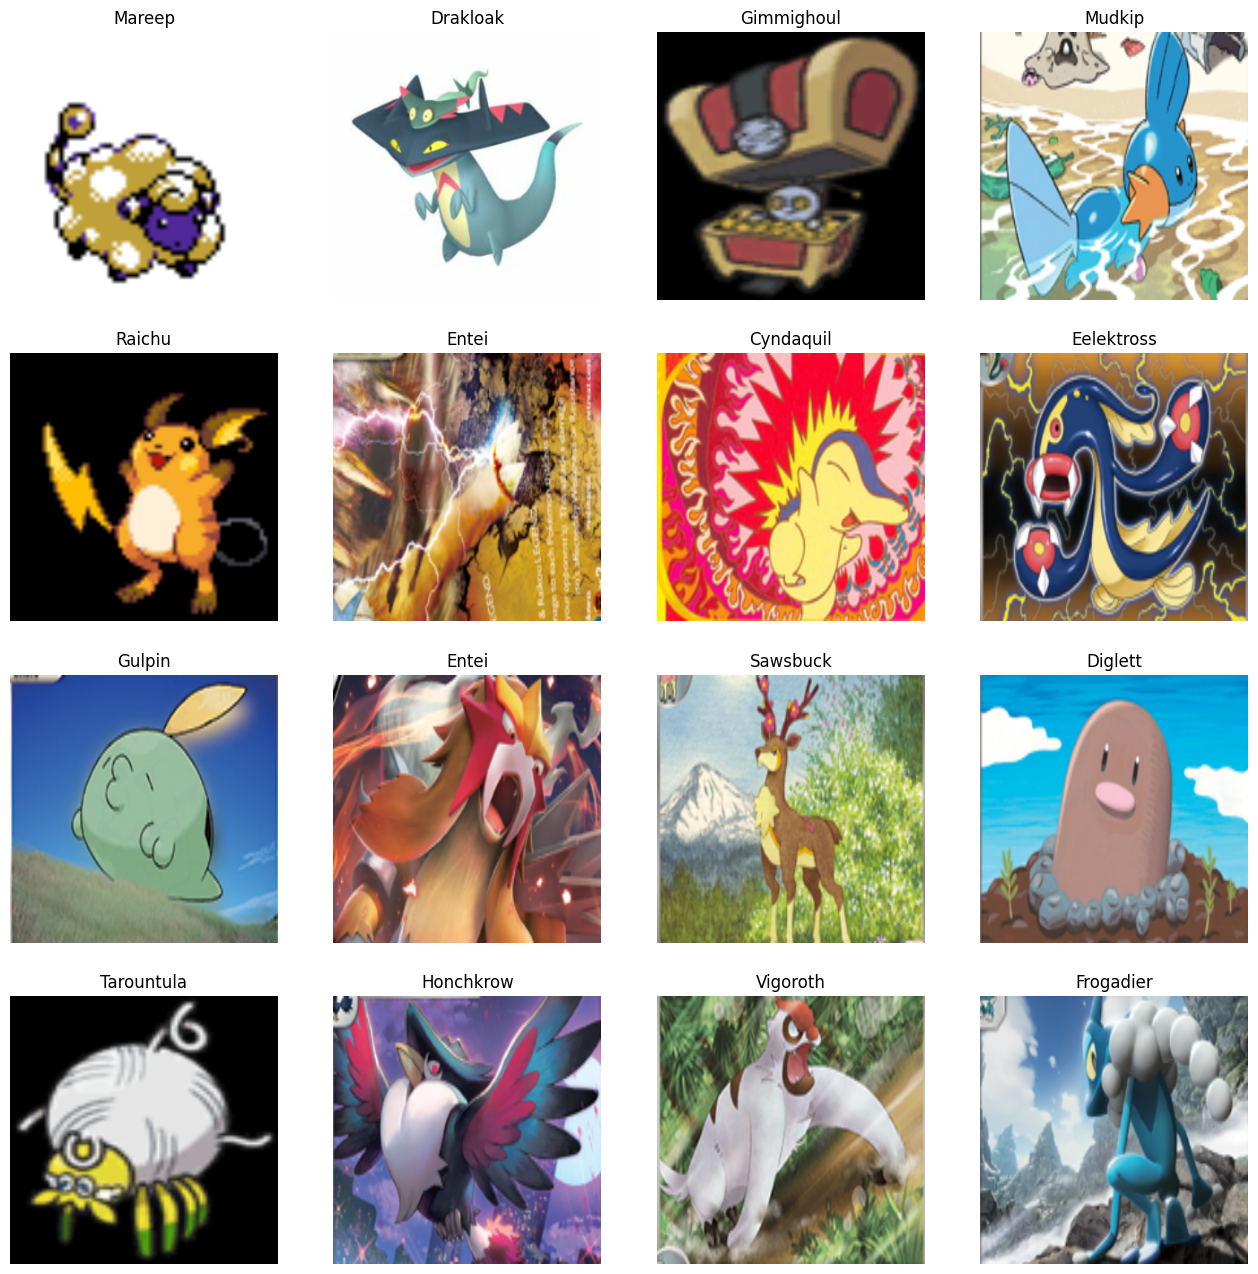

In [5]:
import matplotlib.pyplot as plt

class_names = np.array(train_ds.class_names)


plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

In [6]:
data_augmentation = keras.Sequential(
  [ 
    layers.RandomTranslation(0.05, 0.05, fill_mode="reflect"),
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.8),
    layers.GaussianNoise(10)
  ]
)

2024-04-19 21:53:39.631495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-19 21:53:39.632659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


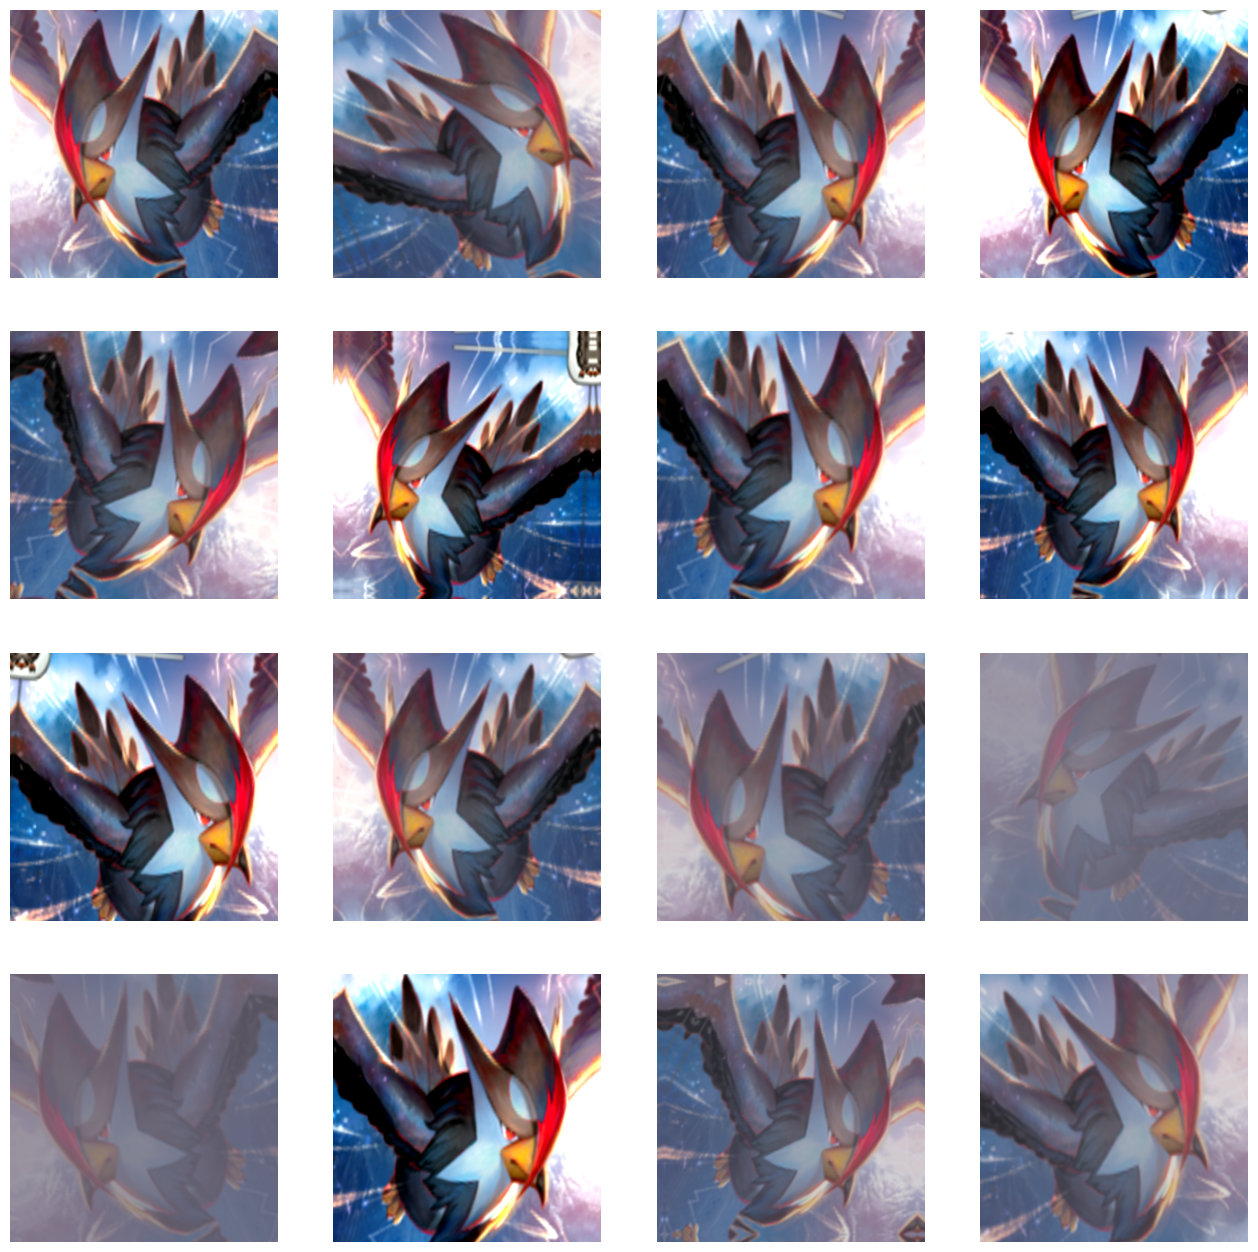

In [7]:
plt.figure(figsize=(16, 16))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

2024-04-19 21:53:45.453778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-19 21:53:45.456585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


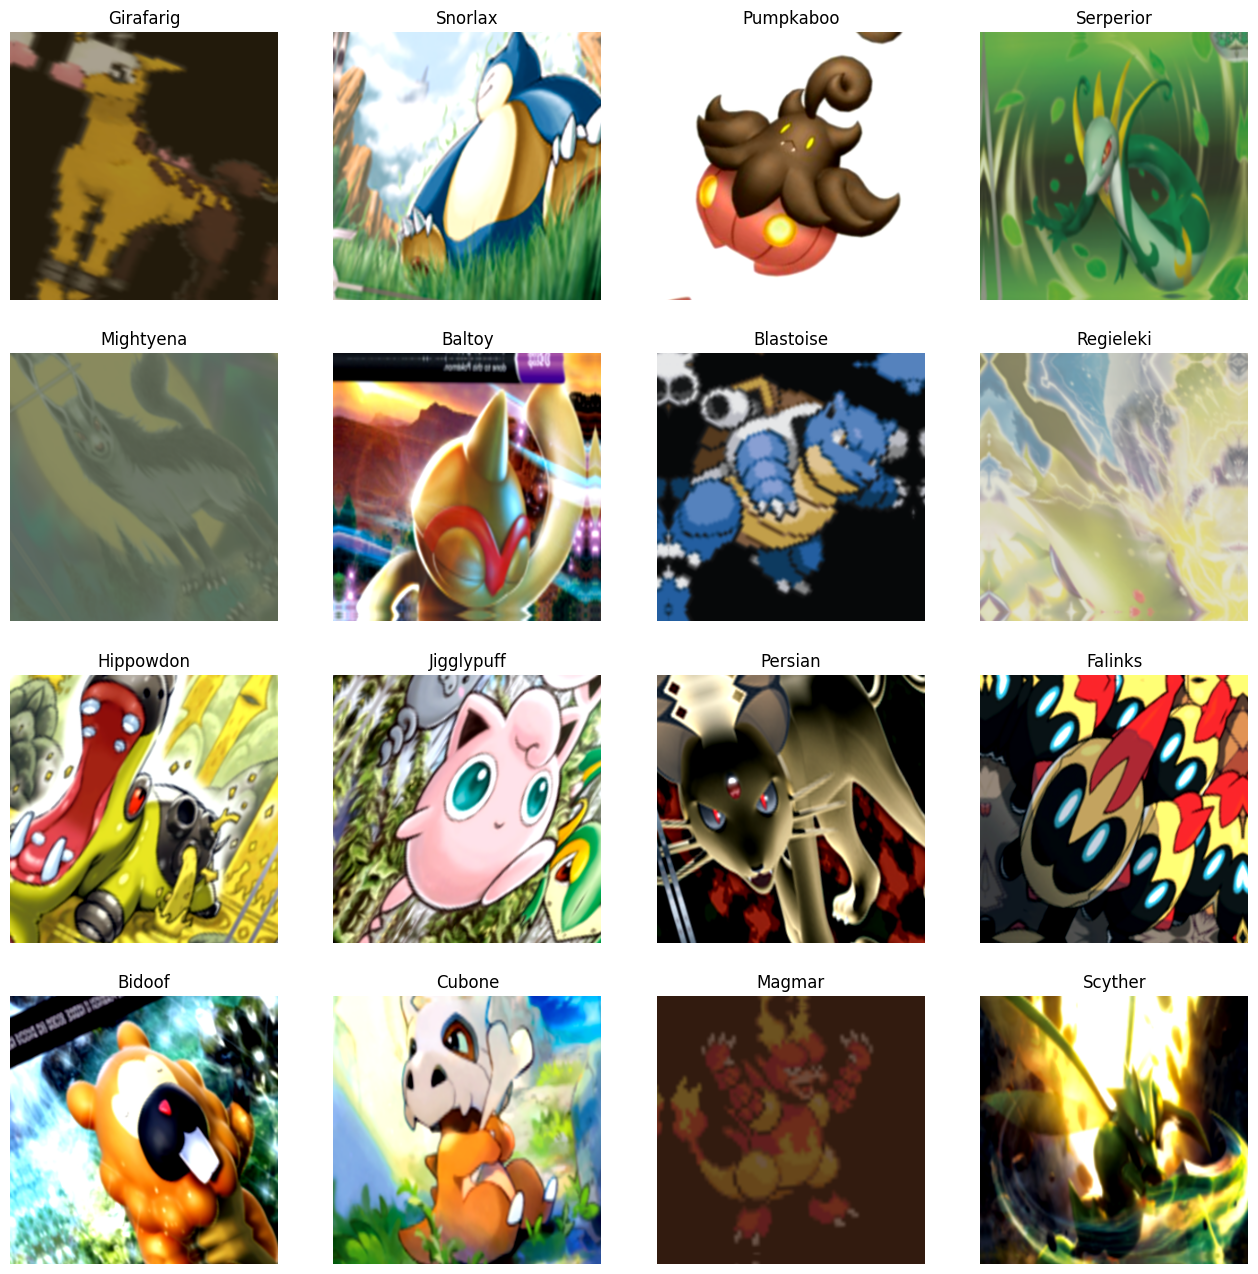

In [8]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .cache()
    .map(lambda x, y: (data_augmentation(x), y),
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [10]:
#In your includes
from keras.applications import Xception

#Since you're using the model for a different task, you'd want to remove the top
imagenet = Xception(weights='imagenet', include_top=True)

#Freeze layers 0 to x

for layer in imagenet.layers[:-5]:
    layer.trainable = False

#To see all the layers in detail and to check trainable parameters
#imagenet.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

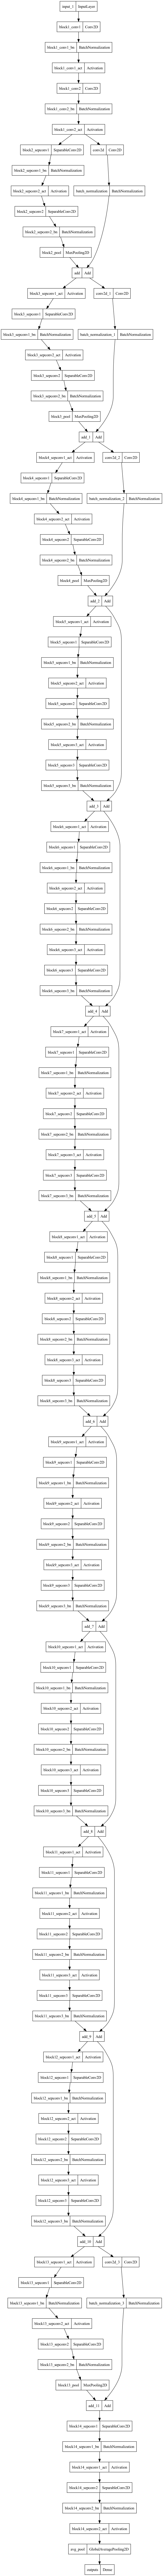

In [11]:
num_classes = len(class_names)

output_layer = layers.Dense(num_classes,
             #activation="softmax",
             name="outputs")

output = output_layer(imagenet.layers[-2].output)

model = tf.keras.Model(
    inputs=imagenet.inputs,
    outputs=output
)

#tf.keras.utils.plot_model(model)

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              #loss =tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="Top5Accuracy"),
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="Top10Accuracy"),
                       #tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="Top5Accuracy")
                      ]
             )

In [13]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from datetime import datetime

patience = 3
now = datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_log_path = os.path.join(cwd, "logs", "fit", now)
model_save_path = os.path.join(cwd, "models", f"{now}-ImageNet.keras")

print("log_dir: ", tensorboard_log_path)
print("model_path: ", model_save_path)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=patience
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=round(patience/3),
    verbose=1,
)


ModelCheckpoint(
    filepath=model_save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    #mode="auto",
    #save_freq="epoch",
    #initial_value_threshold=None,
)






tensor_board = TensorBoard(
    log_dir=tensorboard_log_path,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
    update_freq='epoch',
    #profile_batch=0,
    #embeddings_freq=0,
    #embeddings_metadata=None
)


callbacks=[early_stopping, lr_scheduler, tensor_board]

log_dir:  /Users/fynn/Projects/PokeDex/logs/fit/20240419-215353
model_path:  /Users/fynn/Projects/PokeDex/models/20240419-215353-ImageNet.keras


In [15]:
!rm -rf ../logs/fit

In [16]:
#%tensorboard --logdir logs/fit/

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks,
)

Epoch 1/100


2024-04-19 21:53:53.876560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-04-19 21:53:55.790192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-19 21:53:55.801204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/147 [==============================] - 356s 2s/step - loss: 6.7095 - accuracy: 0.0161 - Top5Accuracy: 0.0393 - Top10Accuracy: 0.0605 - val_loss: 6.6385 - val_accuracy: 0.0173 - val_Top5Accuracy: 0.0457 - val_Top10Accuracy: 0.0711 - lr: 0.0010
Epoch 2/100
147/147 [==============================] - 323s 2s/step - loss: 6.3216 - accuracy: 0.0218 - Top5Accuracy: 0.0625 - Top10Accuracy: 0.0996 - val_loss: 6.3511 - val_accuracy: 0.0284 - val_Top5Accuracy: 0.0620 - val_Top10Accuracy: 0.0927 - lr: 0.0010
Epoch 3/100
147/147 [==============================] - 321s 2s/step - loss: 6.0066 - accuracy: 0.0332 - Top5Accuracy: 0.0907 - Top10Accuracy: 0.1372 - val_loss: 6.2638 - val_accuracy: 0.0332 - val_Top5Accuracy: 0.0778 - val_Top10Accuracy: 0.1120 - lr: 0.0010
Epoch 4/100
147/147 [==============================] - 319s 2s/step - loss: 5.7600 - accuracy: 0.0447 - Top5Accuracy: 0.1184 - Top10Accuracy: 0.1796 - val_loss: 6.1654 - val_accuracy: 0.0418 - val_Top5Accuracy: 0.0908 - val_Top10Accura

In [ ]:
import pandas as pd

df = pd.DataFrame(history.history)

fig, ax = plt.subplots(2, figsize=(16, 16))
df.loc[:,df.columns.str.contains("loss")].plot(ax=ax[0])
df.loc[:,~df.columns.str.contains("loss")].plot(ax=ax[1])

# Predict on new data:

In [ ]:
img_path = "/Users/fynn/Desktop/stat-charizard.png" # charizard
img_path = "/Users/fynn/Desktop/arctincuno.jpg" # arcticuno
img_path = "/Users/fynn/Downloads/Unknown-5" # arcticuno
img_path = "/Users/fynn/Downloads/Unknown-4" # raikou

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
class_names[np.argsort(score)][::-1][:10]

In [ ]:
plt.barh(class_names[np.argsort(score)][-20:], np.sort(score)[-20:]);